# Decomposition

We have seen the different components that can make up a time series: trend, cycle, seasonality, and some good old noise or remainder. We use the components to build different series but, in the real world, we're more interesting in going the other way around: we start with a time series, and split into its (estimated) components.

Let's try some approaches here and see how it goes. We'll start by loading a familiar time series once again:

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

df = pd.read_csv('https://datasets-nixtla.s3.amazonaws.com/air-passengers.csv', parse_dates=['ds'])
df['ds'] = df['ds'] + pd.offsets.MonthEnd() # otherwise CV breaks some join inside the function
df['log_y'] = np.log(df.y+1)
df.head(12)

,unique_id,ds,y,log_y
0,AirPassengers,1949-01-31,112,4.727388
1,AirPassengers,1949-02-28,118,4.779123
2,AirPassengers,1949-03-31,132,4.890349
3,AirPassengers,1949-04-30,129,4.867534
4,AirPassengers,1949-05-31,121,4.804021
5,AirPassengers,1949-06-30,135,4.912655
6,AirPassengers,1949-07-31,148,5.003946
7,AirPassengers,1949-08-31,148,5.003946
8,AirPassengers,1949-09-30,136,4.919981
9,AirPassengers,1949-10-31,119,4.787492


<Axes: >

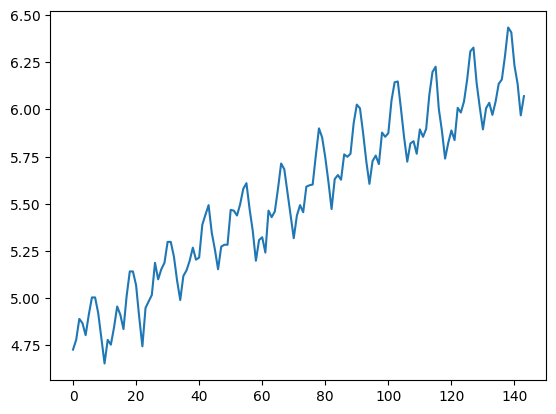

In [ ]:
df.log_y.plot()

It's easy to see there's a trend and a seasonality in this time series. Also, it's expected, since air travel is seasonal and has been growing over time.

## Detrend

One of the first things we can try is to detrend the time series. For example, we can fit a linear regression and subtract the fitted line from the original series. That's what SciPy's `detrend()` method does:

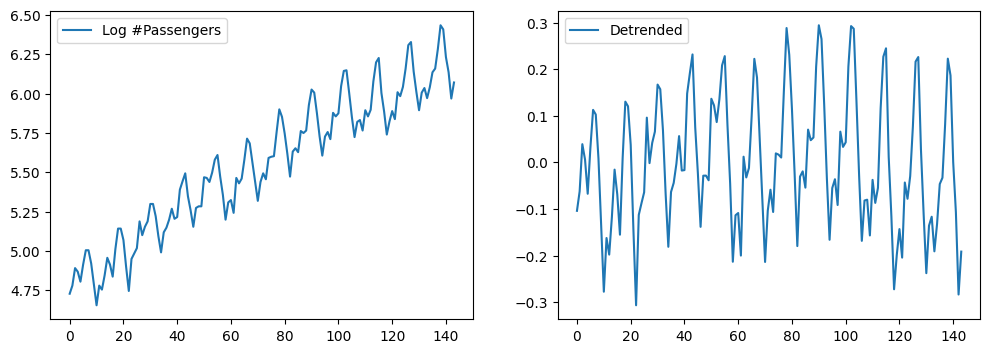

In [ ]:
from scipy import signal

x = df.log_y.values
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(x, label='Log #Passengers')
axs[1].plot(signal.detrend(x), label='Detrended')
axs[0].legend()
axs[1].legend()

The resulting series is visibly detrended, but it still exhibits the seasonal pattern.

But, even if that were not the case, sometimes a simple straight line isn't good enough. The series may exhibit some other long-term behavior that's not captured neither by a linear trend nor by the seasonality.

## Moving Average

Applying a moving average is a way of smoothing (again) a time series and identify its general behavior. Besides, if we know the seasonality, we can make sure the chosen window for the moving average is long enough to include a full season.

There are a few things to keep in mind, though:
- unlike moving averages used elsewhere (for example, trading) which, by design, lag the original values, these moving averages are **centered** - this means we won't have computed values for the first and last few data points (which would be a total deal breaker for trading)
- the fact these averages are centered drives the choice of their length (odd numbers are preferred because they're easier to handle)
- there's no escape from the actual seasonality (such as 12 for monthly series with annual seasonality), so they need to be adjusted for centering

Let's compute a centered moving average for our series while taking the points above into account:

In [ ]:
periods = 12

filt = np.array([0.5] + [1] * (periods - 1) + [0.5]) / periods

centered_ma = df['log_y'].rolling(periods+1, center=True).apply(lambda v: (v*filt).sum())

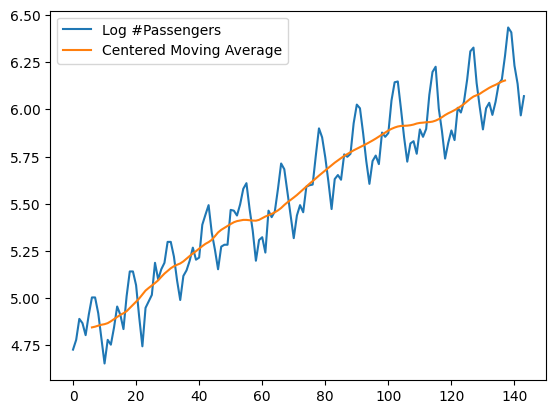

In [ ]:
plt.plot(df.log_y, label='Log #Passengers')
plt.plot(centered_ma, label='Centered Moving Average')
plt.legend()

The moving average tracks the specificities of the trend more closely than a straight line ever could. We can say that this moving average includes both trend and cycle components of our series.

Let's plot the original series, and its newly detrended version side-by-side:

In [ ]:
trend = centered_ma.to_frame().rename(columns={'log_y': 'trend_cycle'})
detrended = (df.log_y - centered_ma).to_frame().rename(columns={'log_y': 'detrended'})
df = pd.concat([df, detrended, trend], axis=1).dropna()

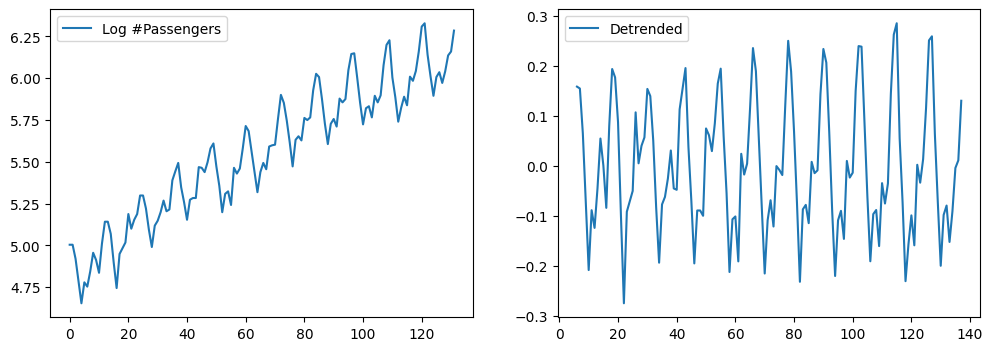

In [ ]:
x = df.log_y.values
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(x, label='Log #Passengers')
axs[1].plot(detrended, label='Detrended')
axs[0].legend()
axs[1].legend()

Looks better, doesn't it? Of course, there's seasonality in the detrended version, but it definitely looks more "horizontal" if you will.

## Hodrick-Prescott Filter

Effectively speaking, the moving average is working like a filter, removing the "noise" from the underlying trend. Filters are a very broad topic in signal processing, but there's one particular filter that I believe is worth mentioning here.

The Hodrick-Prescott Filter is often used for time series in economics. We're not going into its implementation details here, but it can be leveraged directly from statsmodels' if you like. The `lamb` argument must be adjusted according to the periodicity of the series. According to the documentation, the value 129600 is recommended for monthly series such as our.

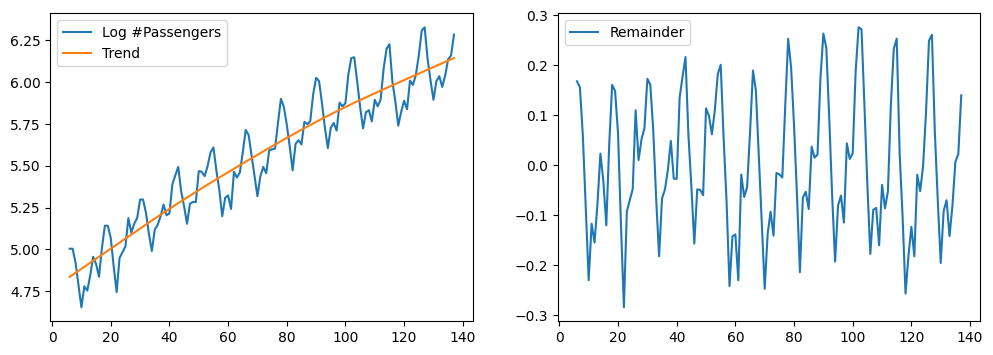

In [ ]:
import statsmodels.api as sm

remainder_part, trend_part = sm.tsa.filters.hpfilter(df.log_y, lamb=129600)
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
df.log_y.plot(ax=axs[0], label='Log #Passengers')
axs[0].plot(trend_part, label='Trend')
axs[0].legend()
axs[1].plot(remainder_part, label='Remainder')
axs[1].legend()

## Seasonality

The seasonality seems quite stable over time. So, for the sake of simplicity, let's assume it truly is. How can we tackle the seasonality?

We know that every month of the year, when it comes to air travel, has its own characteristics. We expect higher demand during holidays and summer. So, what if we take the average corresponding to every month over the years?

For example: January 1949, January 1950, etc. So we'll get the "typical" January. And February. And March, and so on and so forth.

In [ ]:
df['month'] = df['ds'].dt.month
seasonal = df.groupby('month')['detrended'].mean()
seasonal

month
1    -0.086331
2    -0.114886
3     0.017071
4    -0.013920
5    -0.009813
6     0.114097
7     0.209128
8     0.202858
9     0.063674
10   -0.075818
11   -0.215694
12   -0.100779
Name: detrended, dtype: float64

There we go! July and August have the highest values, as expected.

We can plot them and visualize the seasonal pattern:

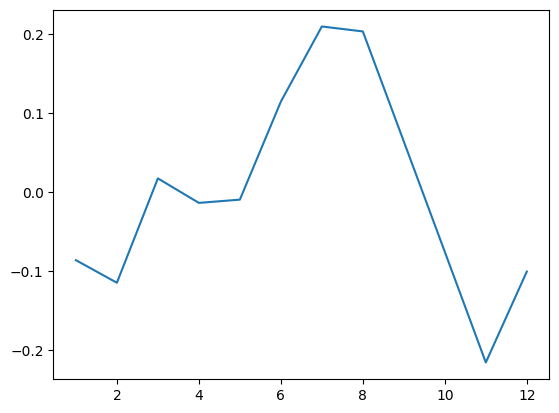

In [ ]:
plt.plot(seasonal)

There's one small detail to take into account, though. The seasonal pattern must have **zero mean**. Since we're decomposing the time series, any increases or decreases over time belong to the trend/cycle component, not the seasonal one. Let's take care of that, and then replicate these values for every corresponding month in the time series:

In [ ]:
seasonal = (seasonal - seasonal.mean())
df['seasonal'] = df['month'].replace(seasonal.to_dict())

We have trend, cycle, and seasonality. So, we can subtract all of them from the original values in order to get the remaining component, the remainder:

In [ ]:
df['remainder'] = df.apply(lambda row: row.log_y - row.trend_cycle - row.seasonal, axis=1)
df

,unique_id,ds,y,log_y,detrended,trend_cycle,month,seasonal,remainder
6,AirPassengers,1949-07-31,148,5.003946,0.158728,4.845218,7,0.209996,-0.051268
7,AirPassengers,1949-08-31,148,5.003946,0.154925,4.849021,8,0.203726,-0.048801
8,AirPassengers,1949-09-30,136,4.919981,0.065521,4.854460,9,0.064541,0.000979
9,AirPassengers,1949-10-31,119,4.787492,-0.071577,4.859069,10,-0.074950,0.003373
10,AirPassengers,1949-11-30,104,4.653960,-0.208333,4.862293,11,-0.214827,0.006494
...,...,...,...,...,...,...,...,...,...
133,AirPassengers,1960-02-29,391,5.971262,-0.152111,6.123373,2,-0.114019,-0.038093
134,AirPassengers,1960-03-31,419,6.040255,-0.090333,6.130588,3,0.017939,-0.108272
135,AirPassengers,1960-04-30,461,6.135565,-0.004059,6.139624,4,-0.013052,0.008993
136,AirPassengers,1960-05-31,472,6.159095,0.011196,6.147899,5,-0.008945,0.020141


We can plot all the components, and it looks like this:

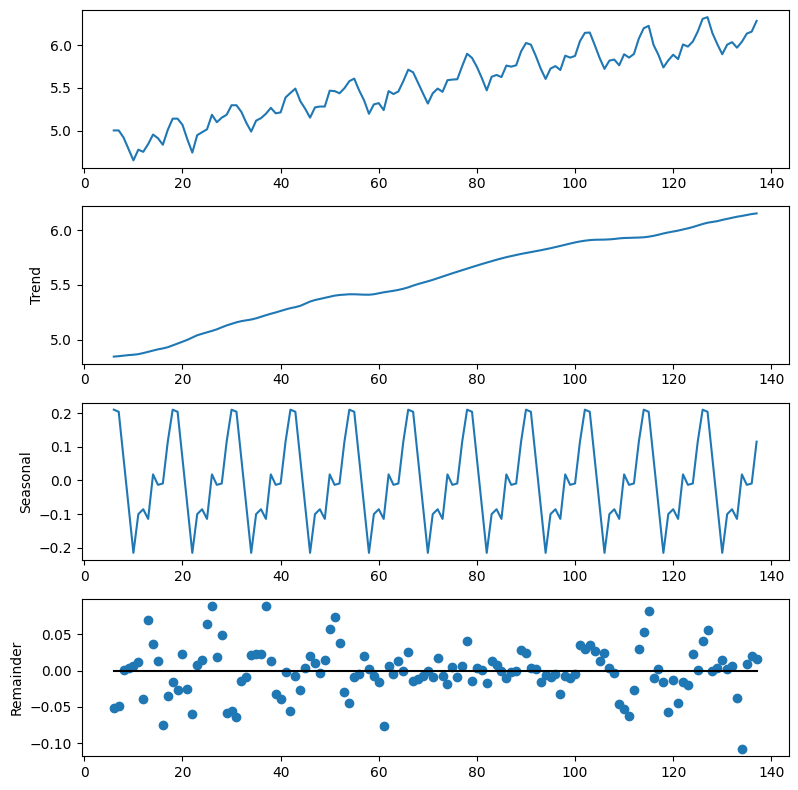

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(8, 8))
df['log_y'].plot(ax=axs[0])
df['trend_cycle'].plot(ax=axs[1])
axs[1].set_ylabel('Trend')
df['seasonal'].plot(ax=axs[2])
axs[2].set_ylabel('Seasonal')
axs[3].scatter(df.index, df['remainder'])
axs[3].set_ylabel('Remainder')
axs[3].plot([df.index[0], df.index[-1]], [0, 0], c='k')
fig.tight_layout()

As you expect, we won't be doing that manually every time. Statsmodels' get us covered.

## Decomposition

We can use statsmodels' `seasonal_decompose()` method to get the components and the plot as well:

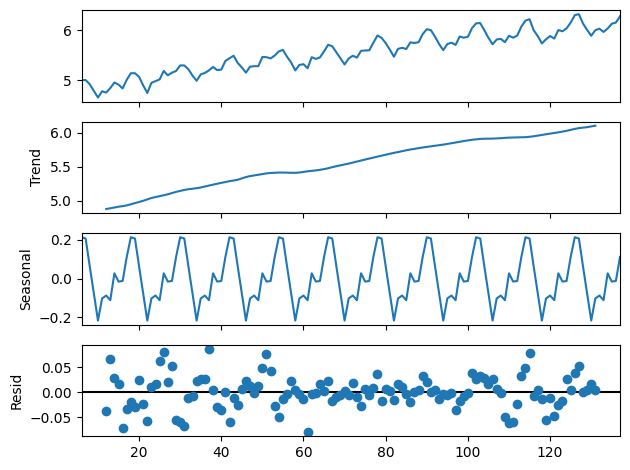

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df[['log_y']], model='additive', period=12)
result.plot();

The components are attributes (`trend`, `seasonal`, and `resid`) of the resulting object returned by the method:

In [ ]:
pd.concat([result.trend, result.seasonal, result.resid], axis=1).tail(20)

,trend,seasonal,resid
118,5.970395,-0.216921,-0.013680
119,5.979850,-0.102488,-0.054317
120,5.987812,-0.087529,-0.011405
121,5.996604,-0.111655,-0.047219
122,6.006496,0.027320,-0.025003
123,6.017378,-0.015397,-0.018044
124,6.029035,-0.012404,0.026002
125,6.043115,0.111970,0.004010
126,6.056861,0.213678,0.037560
127,6.068533,0.207161,0.052243


## Deseasonalize

Deseasonalizing, or seasonally-adjusting, is a fairly common practice especially when it comes to economics. By removing the seasonal component, it may get easier to spot the ups and downs in the economy.

Let's subtract the seasonal component from the original data:

In [ ]:
df.ds

6     1949-07-31
7     1949-08-31
8     1949-09-30
9     1949-10-31
10    1949-11-30
         ...    
133   1960-02-29
134   1960-03-31
135   1960-04-30
136   1960-05-31
137   1960-06-30
Name: ds, Length: 132, dtype: datetime64[ns]

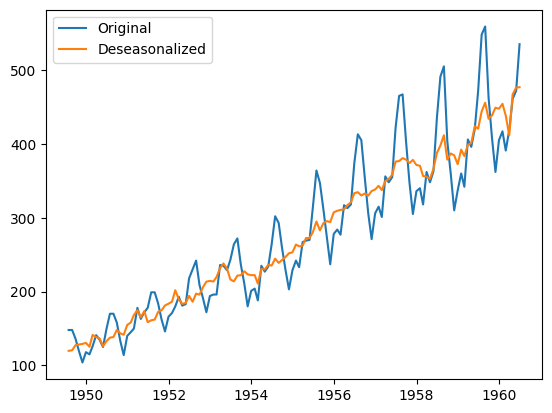

In [ ]:
plt.plot(df.ds, df.y, label='Original')
deseasonalized = df['log_y'] - df['seasonal']
plt.plot(df.ds, np.exp(deseasonalized)-1, label='Deseasonalized')
plt.legend()

See? Even though there's a sequence of ever increasing highs (in the summer months), there are some clear dips (such as 1954 and 1958) that are only visible once the data is adjusted for seasonality.

## Strength

How strongly trending a series is? How strong is the seasonality in it?

One can compare the variance of the remainders to the variance of their combinations either with the trend or the seasonal components. In general, values above 0.6 indicate a strong component, either trend or seasonality.

$$
\Large
F_T = \text{max}\left(0, 1 - \frac{\sigma^2(R_t)}{\sigma^2(R_t+T_t)}\right)
$$

$$
\Large
F_S = \text{max}\left(0, 1 - \frac{\sigma^2(R_t)}{\sigma^2(R_t+S_t)}\right)
$$

Let's compute the strenghts for the components we found in our series:

In [ ]:
# Trend
strength_trend = max(0, 1-df['remainder'].var()/(df['remainder']+df['trend_cycle']).var())

# Season
strength_season = max(0, 1-df['remainder'].var()/(df['remainder']+df['seasonal']).var())

strength_trend, strength_season

(0.9926659257221605, 0.9330964213940351)

A very strong trend, and a quite strong seasonality.

## Seasonal Trend Loess (STL) Decomposition

However simple, the traditional decomposition of time series has two major drawbacks:
- the centering of the moving average makes the decomposition incomplete and forecasting impossible since the last few elements - the most important ones when it comes to forecasting - are missing in the trend
- the seasonality is assumed to be constant over time

The STL decomposition addresses these points by using LOESS to estimate both the general trend and the inner trends in seasonality.

In statsmodels, we can use the `STL` class to fit the decomposition model. The `period` argument specifies the length of the seasonality (12, in our case), and the `seasonal` argument - as confusing as its name may be - specifies how many seasons should be used to fit seasonality's inner trends using LOESS.

We'll see STL in much more detail in the next chapter. For now, let's see an example of its output.

In [ ]:
from statsmodels.tsa.seasonal import STL

stl = STL(df.log_y, period=12, seasonal=7)
res = stl.fit()

pd.concat([res.trend, res.seasonal, res.resid], axis=1).tail(10)

,trend,season,resid
128,6.074548,0.065633,-0.000296
129,6.085144,-0.069806,-0.004071
130,6.095732,-0.205437,0.004108
131,6.106327,-0.120986,0.021012
132,6.116929,-0.088866,0.007419
133,6.127531,-0.162649,0.006379
134,6.138122,-0.065787,-0.032080
135,6.148691,-0.029103,0.015978
136,6.159242,0.003345,-0.003492
137,6.169775,0.117243,-0.002884


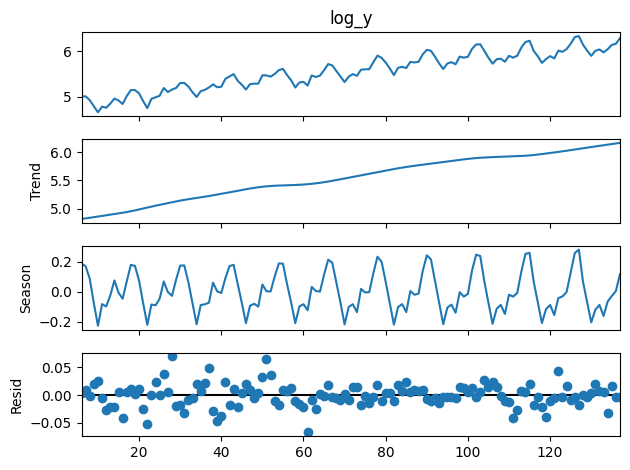

In [ ]:
fig = res.plot()